In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!nvidia-smi

Sat Apr  5 16:30:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
%pip install "ultralytics<=8.3.40" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.2/112.6 GB disk)


In [ ]:
from roboflow import Roboflow

rf = Roboflow(api_key="bSwZyR14ppCIGLFaiVra")
project = rf.workspace("bk-cbs-ds-type17").project("bkcbscountingsdataset")
version = project.version(10)

dataset = version.download("yolov11")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to BKCBSCountingsDataset-10 in yolov11:: 100%|██████████| 13964/13964 [00:04<00:00, 3134.93it/s]


In [ ]:
!yolo task=detect \
  mode=train \
  model=yolo11n.pt \
  data={dataset.location}/data.yaml \
  epochs=50 \
  imgsz=640 \
  batch=16 \
  name=pipe_counter_yolo11


100% 5.35M/5.35M [00:00<00:00, 6.12MB/s]
New https://pypi.org/project/ultralytics/8.3.102 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/BKCBSCountingsDataset-10/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=pipe_counter_yolo11, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=Fals

In [ ]:
from google.colab import files
files.download("runs/detect/pipe_counter_yolo11/weights/best.pt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Tạo thư mục chứa mô hình (nếu cần)
!mkdir -p /content/drive/MyDrive/yolo_models/

# Copy file best.pt vào Drive
!cp runs/detect/pipe_counter_yolo11/weights/best.pt /content/drive/MyDrive/yolo_models/pipe_counter_best.pt


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



image 1/1 /content/BKCBSCountingsDataset-10/test/images/2022_10_03_11_17_IMG_0536_JPG.rf.93f39b23e3f73be8d38d384dca5e4d36.jpg: 640x640 50 IQA1900s, 12.6ms
Speed: 2.6ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
✅ Số lượng mô hình dự đoán: 50
🧮 Số lượng đếm thủ công: 50
🎯 Chính xác!


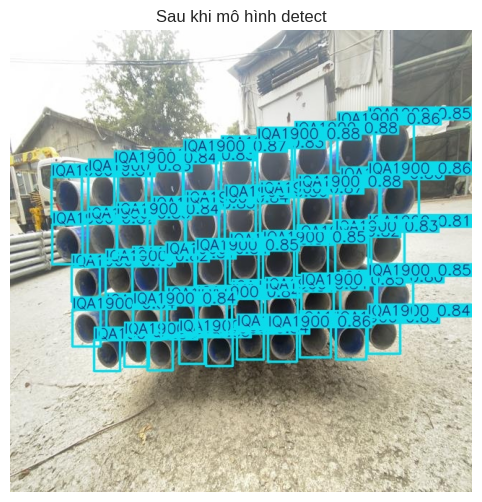

In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import os
import shutil

# Nhập ảnh cần test
image_path = "/content/BKCBSCountingsDataset-10/test/images/2022_10_03_11_17_IMG_0536_JPG.rf.93f39b23e3f73be8d38d384dca5e4d36.jpg"  # 🖼️ Thay ảnh thật ở đây

# Nhập số lượng ống nước bạn đếm được bằng tay
ground_truth_count = 50  # 📝 Bạn điền con số thực tế tại đây


# Xóa kết quả cũ nếu có
if os.path.exists("runs/detect/predict"):
    shutil.rmtree("runs/detect/predict")

# Load mô hình đã huấn luyện
model = YOLO("runs/detect/pipe_counter_yolo11/weights/best.pt")

# Chạy dự đoán
results = model.predict(source=image_path, save=True, save_txt=False)

# Đếm số lượng ống nước
for r in results:
    predicted_count = len(r.boxes)
    print("✅ Số lượng mô hình dự đoán:", predicted_count)
    print("🧮 Số lượng đếm thủ công:", ground_truth_count)
    print("🎯 Chính xác!" if predicted_count == ground_truth_count else f"⚠️ Sai lệch: {abs(predicted_count - ground_truth_count)}")

# Tìm ảnh kết quả vừa tạo
predict_folder = "runs/detect/predict"
predicted_images = [f for f in os.listdir(predict_folder) if f.endswith(".jpg")]

if predicted_images:
    predicted_img_path = os.path.join(predict_folder, predicted_images[0])
    img = cv2.imread(predicted_img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Hiển thị ảnh
    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.title("Sau khi mô hình detect")
    plt.axis("off")
    plt.show()
else:
    print("❌ Không tìm thấy ảnh sau khi dự đoán!")

Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Liberation Sans.
Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Liberation Sans.


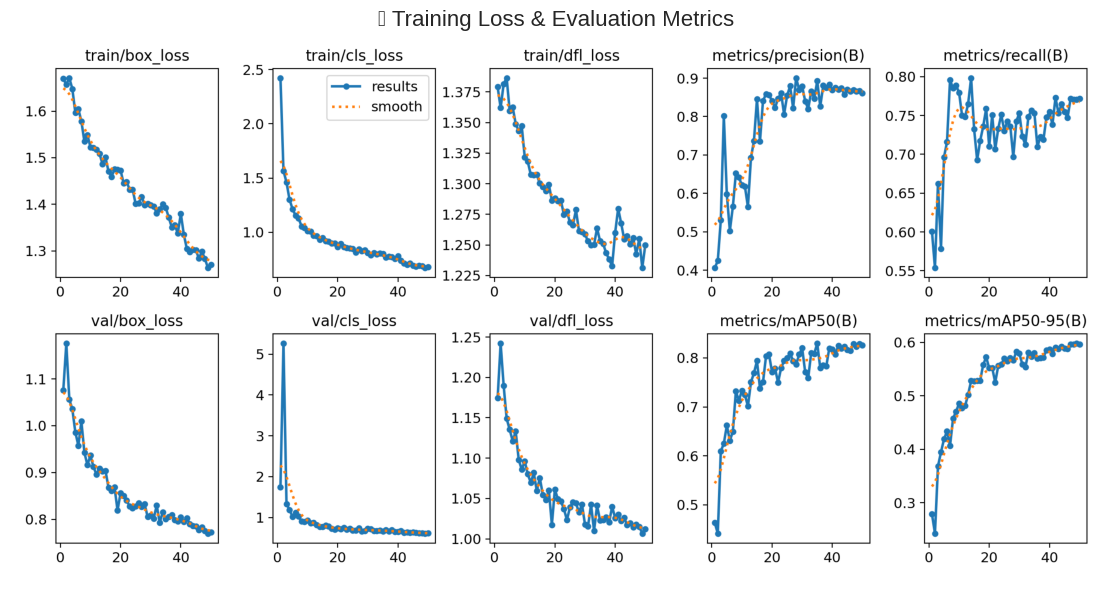

🧠 Ý nghĩa biểu đồ:

    • box_loss: lỗi khi dự đoán bounding box (vị trí và kích thước).
    • cls_loss: lỗi phân loại class.
    • dfl_loss: Distribution Focal Loss - cải thiện định vị.
    • mAP@0.5: mean Average Precision ở IoU = 0.5 (càng cao càng tốt).
    • mAP@0.5:0.95: trung bình mAP từ IoU 0.5 đến 0.95 - độ chính xác tổng quát hơn.
    


Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
Glyph 7853 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND DOT BELOW}) missing from font(s) Liberation Sans.
Glyph 7847 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND GRAVE}) missing from font(s) Liberation Sans.
Glyph 7851 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND TILDE}) missing from font(s) Liberation Sans.
Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
Glyph 7853 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND DOT BELOW}) missing from font(s) Liberation Sans.
Glyph 7847 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND GRAVE}) missing from font(s) Liberation Sans.
Glyph 7851 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND TILDE}) missing from font(s) Liberation Sans.


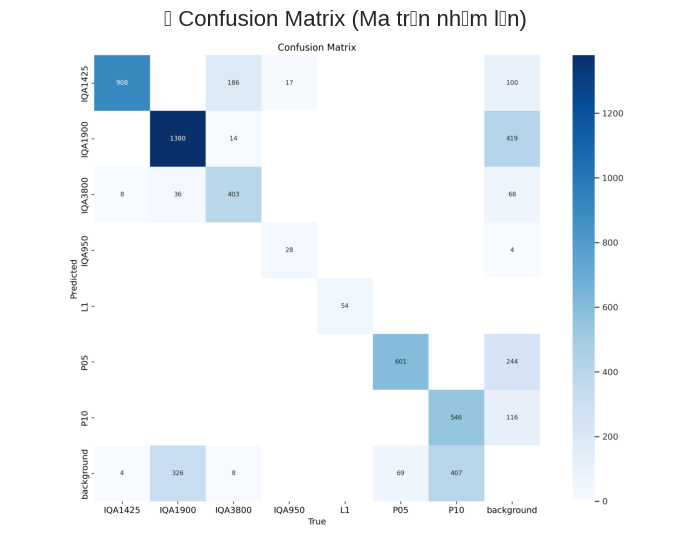

🧠 Ý nghĩa:

    • Hàng: class thực tế (ground truth).
    • Cột: class mô hình dự đoán.
    • Đường chéo chính: số lượng dự đoán đúng.
    • Nếu có nhiều điểm lệch khỏi đường chéo → mô hình dễ nhầm lẫn giữa các class.
    


In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

exp_path = "runs/detect/pipe_counter_yolo11"

# Tùy chỉnh style đẹp
plt.style.use("seaborn-v0_8-darkgrid")

# 1️⃣ Hiển thị biểu đồ metrics/loss
results_img_path = os.path.join(exp_path, "results.png")
if os.path.exists(results_img_path):
    img1 = cv2.imread(results_img_path)
    img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 6))
    plt.imshow(img1_rgb)
    plt.title("📉 Training Loss & Evaluation Metrics", fontsize=16)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    print("🧠 Ý nghĩa biểu đồ:")
    print("""
    • box_loss: lỗi khi dự đoán bounding box (vị trí và kích thước).
    • cls_loss: lỗi phân loại class.
    • dfl_loss: Distribution Focal Loss - cải thiện định vị.
    • mAP@0.5: mean Average Precision ở IoU = 0.5 (càng cao càng tốt).
    • mAP@0.5:0.95: trung bình mAP từ IoU 0.5 đến 0.95 - độ chính xác tổng quát hơn.
    """)
else:
    print("❌ Không tìm thấy results.png")

# 2️⃣ Hiển thị confusion matrix (ma trận nhầm lẫn)
conf_matrix_path = os.path.join(exp_path, "confusion_matrix.png")
if os.path.exists(conf_matrix_path):
    img2 = cv2.imread(conf_matrix_path)
    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(7, 7))
    plt.imshow(img2_rgb)
    plt.title("📊 Confusion Matrix (Ma trận nhầm lẫn)", fontsize=16)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    print("🧠 Ý nghĩa:")
    print("""
    • Hàng: class thực tế (ground truth).
    • Cột: class mô hình dự đoán.
    • Đường chéo chính: số lượng dự đoán đúng.
    • Nếu có nhiều điểm lệch khỏi đường chéo → mô hình dễ nhầm lẫn giữa các class.
    """)
else:
    print("⚠️ Không tìm thấy confusion_matrix.png")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
